# First test
Updated conda environment, updated versions of openMM and openFF, newest openFF forcefield

In [1]:
import openff.toolkit
import openmm
print("ff_name: openff_unconstrained-2.1.0.offxml")
print("ff_version: ", openff.toolkit.__version__)
print("simulation_type: tMD water solution")
print("md_engine: openMM")
print("version: ", openmm.__version__)
print("steps_time: 5.0")

ff_name: openff_unconstrained-2.1.0.offxml
ff_version:  0.14.3
simulation_type: tMD water solution
md_engine: openMM
version:  8.0
steps_time: 5.0


md_experiment_uuids:
1. fc57851e-b654-4338-bcdd-faa28ec66253
2. 7a5837f2-e4ad-4e17-a2c3-6e5e956f938b
note that there are two uuis, one for the initial batch and one to fix some errors that resulted in crashes in the simulation. But in principal, these two are the same. 

- mdfp_experiment_uuid: fc57851e-b654-4338-bcdd-faa28ec66253
- confgen_uuid: 11093a30-b6d0-4e3f-a22b-8dcad60d6a11


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'




2023.03.3


In [3]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
print(column_names)
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]
df_mdfps = pd.DataFrame({'confid': confids, 'molregno': molregnos, 'mdfp': mdfps, 'vp': vps})

3019 results fetched
['confid', 'molregno', 'mdfp', 'vp']


In [4]:
#some checks: how many datapoints do we have? Are we missing any?
print(len(mdfps),' MDFPs')
print(len(vps),' VPs')
cur.execute("SELECT count(*) FROM cs_mdfps_schema.experimental_data")
print(cur.fetchall(), ' experimental data points')
cur.execute("SELECT molregno FROM cs_mdfps_schema.experimental_data")
molregnos_with_vp = cur.fetchall()
molregnos_with_vp = [r[0] for r in molregnos_with_vp]
missing_molregnos = set(molregnos_with_vp) - set(molregnos)
print(len(missing_molregnos), ' missing molregnos')
#we will have to fix this...
#THESE ARE ACTUAL ERRORS IN THE SIMULATIONS FOR DIFFERENT REASONS, #TODO: FIX THIS
simulation_error_confids = [1645,1891,2048,2147,1220,1239,1382,1490,1519,2527,2851,2877,2924,3085,3155,3526,3667,3748,4107,3170]
radical_error_confids = [1816,1416]
stereo_error_confids = [1890,1439,1508,2373,2797,3341,3610,3784]
mdfp_missing_errors_should_be_fixed_confids = [2044,2168,2516,2820,3138,3159,3726,4202]
charge_errors_confids = [2058,2342]
charge_confgen_errors_confids = [1205,3075,3547,4137]
unasigned_bonderror_confids = [3736]
unasigned_angle_error_confids = [4078]
#print sum of lenght of these errors
print(len(simulation_error_confids)+len(radical_error_confids)+len(stereo_error_confids)+len(mdfp_missing_errors_should_be_fixed_confids)+len(charge_errors_confids)+len(charge_confgen_errors_confids)+len(unasigned_bonderror_confids)+len(unasigned_angle_error_confids), ' errors in the simulations')

3019  MDFPs
3019  VPs
[(3066,)]  experimental data points
47  missing molregnos
46  errors in the simulations


In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress
import numpy as np
from sklearn.model_selection import GroupKFold
def train_pred_xgboost(df,params,splits=5):
    gkf = GroupKFold(n_splits=splits)

    # Create an empty list to store the indices of each fold
    fold_indices = []

    # Group the data by 'molregno'
    groups = df['molregno']

    # Iterate over each fold
    for train_idx, test_idx in gkf.split(df, groups=groups):
        fold_indices.append((train_idx, test_idx))

    y = df['vp']  
    params = params
    output = ([],[],[],[])

    # Iterate over each fold
    for fold, (train_idx, test_idx) in enumerate(fold_indices):
        # Split the data into train and test sets for this fold
        X_train = np.array(df['mdfp'].iloc[train_idx].tolist())  # Convert lists to NumPy arrays
        X_test = np.array(df['mdfp'].iloc[test_idx].tolist())
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        molregnos_test = df['molregno'].iloc[test_idx]
        confids_test = df['confid'].iloc[test_idx]
        

        # Create DMatrix for training and testing
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False

        )
        pp = model.predict(dtest)

        output[0].append(y_test)
        output[1].append(pp)
        output[2].append(molregnos_test)
        output[3].append(confids_test)
        rmse = np.sqrt(mean_squared_error(y_test, pp, squared=False))
        print(f"Fold {fold + 1}: RMSE = {rmse}")
    return output



def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue
def density_plot(real,prediction,print_stats=True,title = None):
    if print_stats:
        slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(real, prediction)
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)
    fsize = 20
    fig = plt.figure(1, figsize=(10, 6.15))
    ax = plt.subplot(111)
    lower = min(prediction + real) - 2
    upper = max(prediction + real) + 2
    x = np.linspace(lower, upper,100)
    y = slope_mdfp_d*x+intercept_mdfp_d
    plt.plot(x, y, '-r')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

    import statsmodels.api as sm
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction],var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])

    sc = plt.scatter(real, prediction, lw=0, c=z, s=10, alpha = 0.9)

    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=fsize)

    plt.xlabel(r'Exp. VP (log10 kPa)', fontsize=fsize)
    plt.ylabel(r'Predicted VP (log10 kPa)', fontsize=fsize)
    plt.setp(ax.get_xticklabels(), fontsize=fsize)
    plt.setp(ax.get_yticklabels(), fontsize=fsize)
    plt.grid(1,"both")
    plt.axis([lower, upper, lower, upper])
    plt.text(0.05, 0.95, f'RMSE: {this_rmse:.2f}\nMAE: {this_mae:.2f}\nR2: {r2:.2f}', transform=ax.transAxes, fontsize=fsize, verticalalignment='top')
    #make square
    ax.set_aspect('equal', 'box')
    if title is not None:
        plt.title(title, fontsize=fsize)
    plt.show()


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2120086081380206
Fold 2: RMSE = 1.1813995099300418
Fold 3: RMSE = 1.1496915511718304


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.2512689517410922
Fold 5: RMSE = 1.1285220740756896
RMSE:  1.409033519951439
MAE:  0.8752082787651263
R2:  0.8479784920717834


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


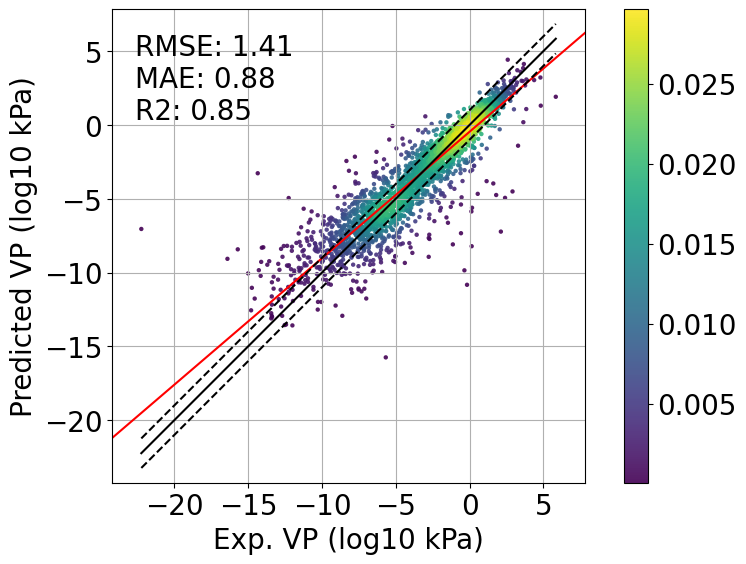

In [6]:
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5)
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real,prediction)


## Look at some outliers

-15.743326 -22.22914798835785
187393-00-6


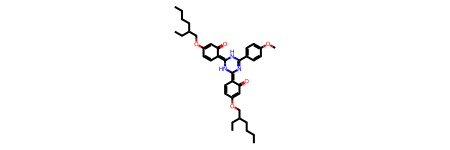

In [7]:
print(min(prediction),min(real))
#that one outlier seems strange, lets look at it
from rdkit import Chem
smiles = '[CH3]-[CH2]-[CH2]-[CH2]-[CH](-[CH2]-[CH3])-[CH2]-[O]-[C]1=[CH]-[C](=[O])/[C](=[C]2\[N]=[C](-[c]3:[cH]:[cH]:[c](-[O]-[CH3]):[cH]:[cH]:3)-[NH]/[C](=[C]3/[CH]=[CH]-[C](-[O]-[CH2]-[CH](-[CH2]-[CH3])-[CH2]-[CH2]-[CH2]-[CH3])=[CH]-[C]-3=[O])-[NH]-2)-[CH]=[CH]-1'
import cirpy
smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(smiles)))    
print(cirpy.resolve(smiles, 'cas'))
Chem.MolFromSmiles(smiles)

In [8]:
#experiemtnal value is 5.9e-20 Pa, so log(kPa)=
reach_val = 5.9e-20/1000
#another source (echmi) says  1.37E-13mmHg, lets convert this to kPa
echmi_val = 1.37e-13 * 0.133322
#Chemspired says 0.0 +- 2.6 mmHg, lets convert this to kPa
chemspire_val_lower = -2.6* 0.133322
chemspire_val_upper = 2.6* 0.133322
print(reach_val, echmi_val, chemspire_val_lower, chemspire_val_upper)
#do we remove this point?
#get the index of the outlier
index = real.index(-22.22914798835785)
print(index)
#remove the outlier
real_no_outlier = real.copy()
real_no_outlier.pop(index)
prediction_no_outlier = prediction.copy()
prediction_no_outlier.pop(index)

slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction_no_outlier, real_no_outlier)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)

5.9e-23 1.8265114e-14 -0.3466372 0.3466372
2329
RMSE:  1.3819090355316468
MAE:  0.8704681890348623


In [9]:
print(min(real_no_outlier),min(prediction_no_outlier))
smiles = '[CH3]-[CH2]-[O]-[c]1:[n]:[c](-[F]):[cH]:[c]2:[n]:[c](-[S](=[O])(=[O])-[NH]-[c]3:[c](-[Cl]):[cH]:[cH]:[cH]:[c]:3-[C](=[O])-[O]-[CH3]):[n]:[n]:1:2'
smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(smiles)))
print(cirpy.resolve(smiles, 'cas'))
Chem.MolFromSmiles(smiles)
#vap according to Unitated States Environmental Protection Agency
USEPA_val3 = 3e-16/7.5
print(USEPA_val3)

-16.397976925271976 -15.743326
147150-35-4
3.9999999999999997e-17


In [10]:
#lets also just get this out of the way: predicting the mean and look at values
mean = np.mean(vps)
mean_array = np.full(len(vps), mean)
#get r2, rmse and mae
mae = mean_absolute_error(np.array(vps), mean_array)
rmse = mean_squared_error(np.array(vps), mean_array, squared=False)
print('RMSE: ', rmse)
print('MAE: ', mae)
#good, we are not falling in that pitfall.



RMSE:  3.6127325949542177
MAE:  3.0145109987475487


In [11]:
#get real vps for datapoints with high prediction error
high_error_vps = []
for r,p in zip(real, prediction):
    if abs(r-p)>1:
        high_error_vps.append(r)
print(len(high_error_vps))
#count occurences of these in df
import pandas as pd
df = pd.read_csv('../../../../ShuZe/vp/data cleaning/cleaned_vp_all.tsv', sep='\t')
df = df[df['Temperature'] == 298.15 ]
smiles_list = []
for vp in high_error_vps:
    if len(df[df['Vapour Pressure (log10 kPa)'] == vp]) == 1:
        smiles_list.append(df[df['Vapour Pressure (log10 kPa)'] == vp]['SMILES'].values[0])
    elif len(df[df['Vapour Pressure (log10 kPa)'] == vp]['SMILES']) == 0:
        print('no smiles found')
    else:
        print('multiple smiles found')

845
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multip

656


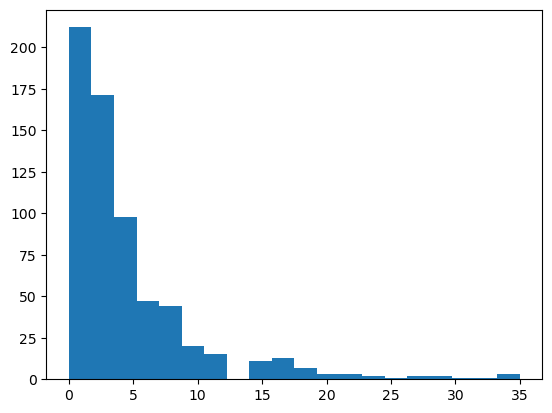

In [12]:
print(len(smiles_list))
#get number of rotatable bonds for these
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
rb = [rdMolDescriptors.CalcNumRotatableBonds(m) for m in mols]
#histogram
import matplotlib.pyplot as plt
plt.hist(rb, bins=20)
plt.show()

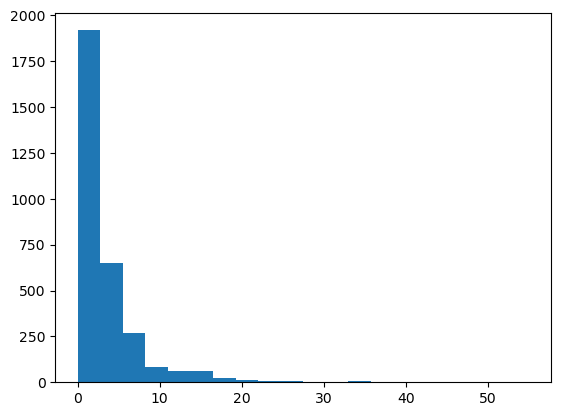

In [13]:
all_mols = [Chem.MolFromSmiles(s) for s in df['SMILES']]
all_rb = [rdMolDescriptors.CalcNumRotatableBonds(m) for m in all_mols]
plt.hist(all_rb, bins=20)
plt.show()

KstestResult(statistic=0.13892617581760067, pvalue=1.4104137824195769e-09, statistic_location=2, statistic_sign=-1)
4.391768292682927 3.1533247256294383


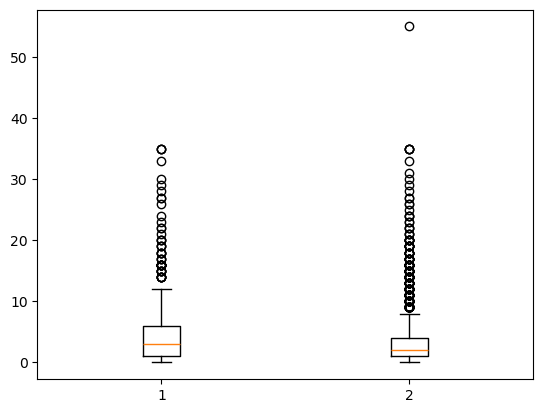

In [14]:
#check if distrubtion is different
from scipy.stats import ks_2samp
print(ks_2samp(rb, all_rb))
print(np.mean(rb), np.mean(all_rb))
#boxplots next to eachoter
import matplotlib.pyplot as plt
plt.boxplot([rb, all_rb])
plt.show()

In [ ]:
#what if we add some more descriptors? how about some of the best rkdit 2d features (estates, molwt and lets also look at logP)

In [35]:
df_mdfps_mdfps = df_mdfps.copy()
#unpack the mdfps and add them to the dataframe
mdfp_features = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfps = df_mdfps_mdfps['mdfp'].tolist()
for i,key in enumerate(mdfp_features):
    df_mdfps_mdfps[key] = [mdfps[j][i] for j in range(len(mdfps))]

In [50]:
#get molblocks for these confids
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("select * from public.conformers where conf_id in %s", (tuple(df_mdfps['confid'].tolist()),))
molblocks = cur.fetchall()
#print columns
column_names = [desc[0] for desc in cur.description]
confids = [r[0] for r in molblocks]
molregnos = [r[1] for r in molblocks]
molblocks = [r[3] for r in molblocks]
mols = [Chem.MolFromMolBlock(m) for m in molblocks]
mols = [Chem.AddHs(m) for m in mols]
#get crippen logP
from rdkit.Chem import Crippen
from rdkit.Chem import EState
from rdkit.Chem import Descriptors
logP = [Crippen.MolLogP(m) for m in mols]
MaxAbsEStateIndex = [Chem.EState.EState.MaxAbsEStateIndex(m) for m in mols]
MinAbsEStateIndex = [Chem.EState.EState.MinAbsEStateIndex(m) for m in mols]
ExactMolWt = [Chem.Descriptors.ExactMolWt(m) for m in mols]


[09:27:07] Warning: molecule is tagged as 3D, but all Z coords are zero


In [55]:
qed = [Chem.QED.qed(m) for m in mols]

In [56]:
#make df with these features
df_mol_features = pd.DataFrame({'confid': confids,  'logP': logP, 'MaxAbsEStateIndex': MaxAbsEStateIndex, 'MinAbsEStateIndex': MinAbsEStateIndex, 'ExactMolWt': ExactMolWt, 'qed': qed})
df_mol_features
#merge with df_mdfps on confid
df_mdfps_features = df_mdfps_mdfps.merge(df_mol_features, on='confid')
df_mdfps_features.columns
#X will be the mdfp features + the mol features
X = df_mdfps_features[mdfp_features+['logP', 'MaxAbsEStateIndex', 'MinAbsEStateIndex','ExactMolWt','qed']].to_numpy()
y = df_mdfps_features['vp']  

In [57]:
#now do the cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

params = params
output = ([], [])
for train, test in tqdm.tqdm(kf.split(X)):
    
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]

    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=False

    )
    # Evaluate the model
    predictions = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(predictions)


5it [00:00,  7.07it/s]


RMSE:  1.359943680681319
MAE:  0.8378424557091395
R2:  0.8584207660844031


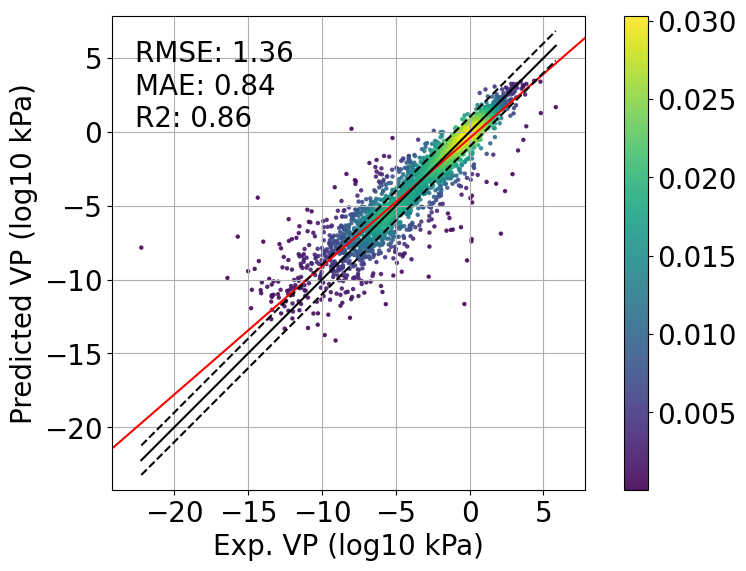

In [58]:
from functools import reduce
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real,prediction)

In [60]:
#wait, fun idea.
from rdkit.Chem import Descriptors
all_descriptors = [Descriptors.CalcMolDescriptors(m) for m in mols]

In [61]:
feature_importance_dict = {'MaxAbsEStateIndex': 398.0,
 'MinAbsEStateIndex': 196.0,
 'qed': 145.0,
 'BCUT2D_CHGHI': 96.0,
 'MinPartialCharge': 86.0,
 'MaxPartialCharge': 79.0,
 'MinEStateIndex': 77.0,
 'FpDensityMorgan1': 72.0,
 'BCUT2D_MRLOW': 68.0,
 'BCUT2D_MWLOW': 67.0,
 'BalabanJ': 62.0,
 'BCUT2D_MWHI': 60.0,
 'BCUT2D_LOGPHI': 58.0,
 'Kappa3': 58.0,
 'BCUT2D_LOGPLOW': 57.0,
 'MolWt': 56.0,
 'BCUT2D_CHGLO': 56.0,
 'PEOE_VSA6': 55.0,
 'FpDensityMorgan3': 54.0,
 'FpDensityMorgan2': 52.0,
 'PEOE_VSA7': 52.0,
 'VSA_EState3': 50.0,
 'PEOE_VSA8': 48.0,
 'BertzCT': 47.0,
 'MinAbsPartialCharge': 46.0,
 'BCUT2D_MRHI': 46.0,
 'VSA_EState8': 45.0,
 'AvgIpc': 43.0,
 'EState_VSA3': 42.0,
 'TPSA': 41.0,
 'VSA_EState7': 40.0,
 'EState_VSA6': 36.0,
 'VSA_EState4': 36.0,
 'VSA_EState5': 35.0,
 'Chi3v': 33.0,
 'PEOE_VSA9': 32.0,
 'EState_VSA5': 32.0,
 'MolLogP': 32.0,
 'Kappa2': 30.0,
 'Chi2n': 29.0,
 'SMR_VSA5': 29.0,
 'MaxAbsPartialCharge': 28.0,
 'HeavyAtomMolWt': 27.0,
 'SMR_VSA10': 27.0,
 'VSA_EState2': 27.0,
 'Chi1v': 26.0,
 'SlogP_VSA2': 26.0,
 'Chi3n': 25.0,
 'Ipc': 25.0,
 'SMR_VSA1': 25.0,
 'VSA_EState9': 25.0,
 'PEOE_VSA10': 24.0,
 'EState_VSA2': 24.0,
 'EState_VSA9': 24.0,
 'HallKierAlpha': 22.0,
 'EState_VSA4': 22.0,
 'Chi2v': 21.0,
 'Chi4v': 20.0,
 'Chi1n': 19.0,
 'Chi4n': 19.0,
 'VSA_EState10': 19.0,
 'PEOE_VSA1': 18.0,
 'EState_VSA8': 17.0,
 'SMR_VSA6': 16.0,
 'SlogP_VSA6': 16.0,
 'EState_VSA7': 16.0,
 'VSA_EState6': 16.0,
 'MolMR': 16.0,
 'LabuteASA': 15.0,
 'VSA_EState1': 15.0,
 'NumValenceElectrons': 14.0,
 'Kappa1': 14.0,
 'Chi1': 13.0,
 'PEOE_VSA11': 13.0,
 'FractionCSP3': 13.0,
 'NumHDonors': 13.0,
 'Chi0n': 12.0,
 'NumRotatableBonds': 12.0,
 'SMR_VSA3': 11.0,
 'SlogP_VSA3': 11.0,
 'Chi0': 10.0,
 'SMR_VSA7': 10.0,
 'SlogP_VSA5': 10.0,
 'EState_VSA10': 9.0,
 'NHOHCount': 9.0,
 'PEOE_VSA2': 8.0,
 'PEOE_VSA5': 8.0,
 'SlogP_VSA1': 7.0,
 'fr_allylic_oxid': 7.0,
 'fr_lactone': 7.0,
 'fr_unbrch_alkane': 7.0,
 'PEOE_VSA4': 6.0,
 'SlogP_VSA10': 6.0,
 'SlogP_VSA4': 6.0,
 'fr_ester': 6.0,
 'fr_para_hydroxylation': 6.0,
 'ExactMolWt': 5.0,
 'Chi0v': 5.0,
 'PEOE_VSA12': 5.0,
 'PEOE_VSA13': 5.0,
 'PEOE_VSA14': 5.0,
 'SMR_VSA9': 5.0,
 'EState_VSA1': 5.0,
 'fr_amide': 5.0,
 'fr_isocyan': 5.0,
 'SlogP_VSA7': 4.0,
 'SlogP_VSA8': 4.0,
 'NumHeteroatoms': 4.0,
 'fr_COO': 4.0,
 'fr_C_S': 4.0,
 'fr_aldehyde': 4.0,
 'fr_alkyl_halide': 4.0,
 'fr_imidazole': 4.0,
 'PEOE_VSA3': 3.0,
 'SlogP_VSA11': 3.0,
 'SlogP_VSA12': 3.0,
 'NOCount': 3.0,
 'NumAliphaticRings': 3.0,
 'NumHAcceptors': 3.0,
 'RingCount': 3.0,
 'fr_Al_OH': 3.0,
 'fr_NH0': 3.0,
 'fr_SH': 3.0,
 'fr_aryl_methyl': 3.0,
 'fr_ketone': 3.0,
 'fr_methoxy': 3.0,
 'fr_pyridine': 3.0,
 'fr_sulfide': 3.0,
 'SMR_VSA4': 2.0,
 'NumAliphaticHeterocycles': 2.0,
 'fr_Ar_N': 2.0,
 'fr_Ar_NH': 2.0,
 'fr_Ar_OH': 2.0,
 'fr_C_O_noCOO': 2.0,
 'fr_NH1': 2.0,
 'fr_aniline': 2.0,
 'fr_bicyclic': 2.0,
 'fr_furan': 2.0,
 'fr_ketone_Topliss': 2.0,
 'fr_nitrile': 2.0,
 'fr_oxime': 2.0,
 'fr_sulfone': 2.0,
 'fr_urea': 2.0,
 'SMR_VSA2': 1.0,
 'HeavyAtomCount': 1.0,
 'NumAromaticCarbocycles': 1.0,
 'NumSaturatedHeterocycles': 1.0,
 'fr_Al_COO': 1.0,
 'fr_Imine': 1.0,
 'fr_Ndealkylation1': 1.0,
 'fr_ether': 1.0,
 'fr_halogen': 1.0,
 'fr_nitroso': 1.0}

In [73]:
#make df out of all_descriptors
df_descriptors = pd.DataFrame(all_descriptors, columns=all_descriptors[0].keys())
df_descriptors['confid'] = confids
df_mdfps_features = df_mdfps_mdfps.merge(df_descriptors, on='confid')

,NumHeavyAtoms,HeavyAtomCount
0,10,10
1,7,7
2,10,10
3,14,14
4,15,15
...,...,...
3014,17,17
3015,19,19
3016,18,18
3017,10,10


In [84]:
#print out the columns
for column in df_mdfps_features.columns:
    print(column)
#chagne NumRotatableBonds_x to NumRotatableBonds, drop NumRotatableBonds_y
df_mdfps_features = df_mdfps_features.rename(columns={'NumRotatableBonds_x': 'NumRotatableBonds'})
df_mdfps_features = df_mdfps_features.drop(columns=['NumRotatableBonds_y'])


confid
molregno
mdfp
vp
NumHeavyAtoms
NumRotatableBonds_x
NumN
NumO
NumF
NumP
NumS
NumCl
NumBr
NumI
water_intra_crf_mean
water_intra_crf_std
water_intra_crf_median
water_intra_lj_mean
water_intra_lj_std
water_intra_lj_median
water_total_crf_mean
water_total_crf_std
water_total_crf_median
water_total_lj_mean
water_total_lj_std
water_total_lj_median
water_intra_ene_mean
water_intra_ene_std
water_intra_ene_median
water_total_ene_mean
water_total_ene_std
water_total_ene_median
water_rgyr_mean
water_rgyr_std
water_rgyr_median
water_sasa_mean
water_sasa_std
water_sasa_median
MaxAbsEStateIndex
MaxEStateIndex
MinAbsEStateIndex
MinEStateIndex
qed
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
NumRadicalElectrons
MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
AvgIpc
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n


In [88]:
#okay so now we try get get a differnt X every time: we get the x most import features and the mdfp features as train
#and then we predict the vp

#first we need to get the indices of the most important features
import operator
sorted_feature_importance_dict = sorted(feature_importance_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_feature_importance_dict


['MaxAbsEStateIndex']
['MaxAbsEStateIndex', 'MinAbsEStateIndex']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge', 'MinEStateIndex']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge', 'MinEStateIndex', 'FpDensityMorgan1']
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge', 'MinEStateIndex', 'FpDensityMorgan1', 'BCUT2D_MRLOW']


In [100]:
len(feature_importance_dict.items())

153

In [109]:
#for each feature, chech how many Nans there are
nans = df_mdfps_features.isna().sum()
print(type(nans))
#for each, print the name and the number of nans
for i in range(len(nans)):
    if nans[i] > 0:
        print(df_mdfps_features.columns[i], nans[i])

<class 'pandas.core.series.Series'>
MaxPartialCharge 1
MinPartialCharge 1
MaxAbsPartialCharge 1
MinAbsPartialCharge 1
BCUT2D_MWHI 1
BCUT2D_MWLOW 1
BCUT2D_CHGHI 1
BCUT2D_CHGLO 1
BCUT2D_LOGPHI 1
BCUT2D_LOGPLOW 1
BCUT2D_MRHI 1
BCUT2D_MRLOW 1


/tmp/ipykernel_372445/2148271619.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if nans[i] > 0:
/tmp/ipykernel_372445/2148271619.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_mdfps_features.columns[i], nans[i])


In [138]:
outputs = []
for x in range(1,len(feature_importance_dict.items())+1):
    most_important_features = [f[0] for f in sorted_feature_importance_dict[:x]]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+most_important_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    outputs.append(output)

5it [00:00,  5.82it/s]
5it [00:00, 14.01it/s]
5it [00:00, 12.72it/s]
5it [00:00, 10.91it/s]
5it [00:00,  9.20it/s]
5it [00:00, 11.71it/s]
5it [00:00, 13.30it/s]
5it [00:00, 11.57it/s]
5it [00:00, 10.00it/s]
5it [00:00,  9.34it/s]
5it [00:00,  8.31it/s]
5it [00:00, 10.22it/s]
5it [00:00,  9.34it/s]
5it [00:00, 10.25it/s]
5it [00:00, 16.02it/s]
5it [00:00, 15.43it/s]
5it [00:00, 12.75it/s]
5it [00:00, 13.53it/s]
5it [00:00, 14.74it/s]
5it [00:00, 12.81it/s]
5it [00:00, 10.42it/s]
5it [00:00, 10.23it/s]
5it [00:00, 12.62it/s]
5it [00:00,  9.89it/s]
5it [00:00, 10.03it/s]
5it [00:00, 10.56it/s]
5it [00:00, 10.77it/s]
5it [00:00,  9.04it/s]
5it [00:00, 12.12it/s]
5it [00:00,  6.80it/s]
5it [00:00,  9.00it/s]
5it [00:00,  8.54it/s]
5it [00:00,  6.24it/s]
5it [00:00, 10.15it/s]
5it [00:00,  7.94it/s]
5it [00:00, 10.81it/s]
5it [00:00, 10.40it/s]
5it [00:00,  8.51it/s]
5it [00:00,  8.64it/s]
5it [00:00,  9.07it/s]
5it [00:00, 11.10it/s]
5it [00:00,  8.26it/s]
5it [00:00,  7.31it/s]
5it [00:00,

XGBoostError: [10:19:38] /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/data/data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(+0xb6361) [0x7ff8b82b6361]
  [bt] (1) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(unsigned long xgboost::SparsePage::Push<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, float, int)+0x5d3) [0x7ff8b83b6dd3]
  [bt] (2) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(xgboost::data::SimpleDMatrix::SimpleDMatrix<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int)+0x321) [0x7ff8b8411d61]
  [bt] (3) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(xgboost::DMatrix* xgboost::DMatrix::Create<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)+0x37) [0x7ff8b8396807]
  [bt] (4) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/libxgboost.so(XGDMatrixCreateFromDense+0x314) [0x7ff8b82de564]
  [bt] (5) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7ff987b2ea4a]
  [bt] (6) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/../../libffi.so.8(+0x5fea) [0x7ff987b2dfea]
  [bt] (7) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x12529) [0x7ff987b46529]
  [bt] (8) /localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x8862) [0x7ff987b3c862]



In [140]:
reals, preds = [], []
maes,rmses,r2s = [],[],[]
from sklearn.metrics import r2_score
for output in outputs:
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    reals.append(real)
    preds.append(pred)
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
    

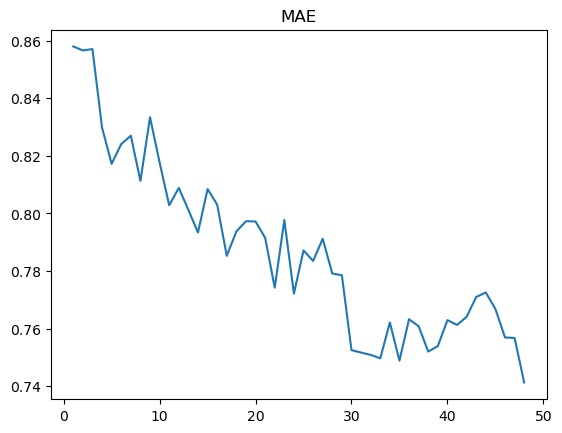

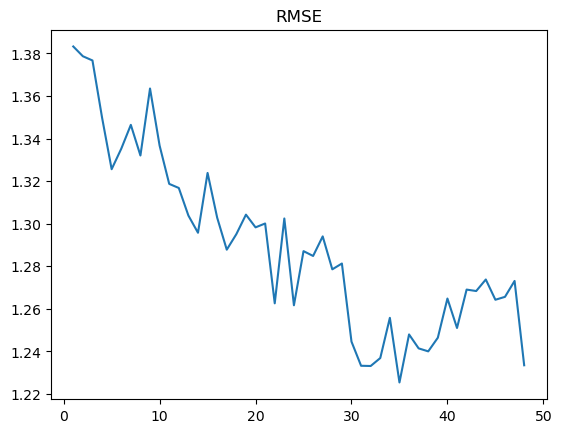

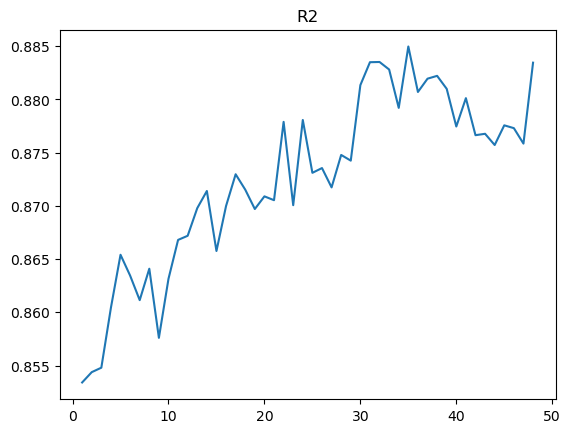

In [141]:
#plot mae, rsme and r2 over x

import matplotlib.pyplot as plt
plt.plot(range(1,len(maes)+1), maes)
plt.title('MAE')
plt.show()
plt.plot(range(1,len(rmses)+1), rmses)
plt.title('RMSE')
plt.show()
plt.plot(range(1,len(r2s)+1), r2s)
plt.title('R2')
plt.show()

In [142]:
#get indices of lowest values for mae, lowest for rsme and highest for r2
mae_index = maes.index(min(maes))
rmse_index = rmses.index(min(rmses))
r2_index = r2s.index(max(r2s))

print('mae index: ', mae_index)
print('rmse index: ', rmse_index)
print('r2 index: ', r2_index)

mae index:  47
rmse index:  34
r2 index:  34


In [116]:
#okay, idk if this makes sense but do this:
#get a list of features for which there is a jump down in the MAE and RMSE and up in R2

#first get the indices of the jumps
mae_jumps = []
rmse_jumps = []
r2_jumps = []
for i in range(len(maes)-1):
    if maes[i+1] < maes[i]:
        mae_jumps.append(i)
    if rmses[i+1] < rmses[i]:
        rmse_jumps.append(i)
    if r2s[i+1] > r2s[i]:
        r2_jumps.append(i)

#check for overlap
overlap = [i for i in mae_jumps if i in rmse_jumps and i in r2_jumps]
print(overlap)
#okay now we repeat the experiment but only with these features
best_features_indices = [f[i] for i,f in enumerate(sorted_feature_importance_dict) if i in overlap]
best_features_indices

[0, 2, 3, 6, 8, 9, 11, 12, 14, 15, 18, 20, 22, 24, 26, 28, 29, 30, 33, 35, 36, 39, 43, 46]


IndexError: tuple index out of range

In [121]:
sorted_feature_importance_dict = sorted(feature_importance_dict.items(), key=operator.itemgetter(1), reverse=True)
selected_features = [sorted_feature_importance_dict[i][0] for i in overlap]


In [122]:
outputs = []
for x in range(1,len(selected_features)+1):
    added_features = selected_features[:x]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    outputs.append(output)

5it [00:00,  7.62it/s]
5it [00:00,  9.86it/s]
5it [00:00, 10.91it/s]
5it [00:00, 11.34it/s]
5it [00:00,  5.96it/s]
5it [00:00,  6.89it/s]
5it [00:00, 13.25it/s]
5it [00:00, 13.43it/s]
5it [00:00,  9.16it/s]
5it [00:00, 13.45it/s]
5it [00:00,  8.56it/s]
5it [00:00,  9.18it/s]
5it [00:00, 12.53it/s]
5it [00:00, 11.03it/s]
5it [00:00, 11.27it/s]
5it [00:01,  4.18it/s]
5it [00:00,  9.43it/s]
5it [00:00,  9.53it/s]
5it [00:00, 12.46it/s]
5it [00:00, 10.78it/s]
5it [00:01,  4.74it/s]
5it [00:00, 13.19it/s]
5it [00:00,  6.89it/s]
5it [00:00,  8.76it/s]


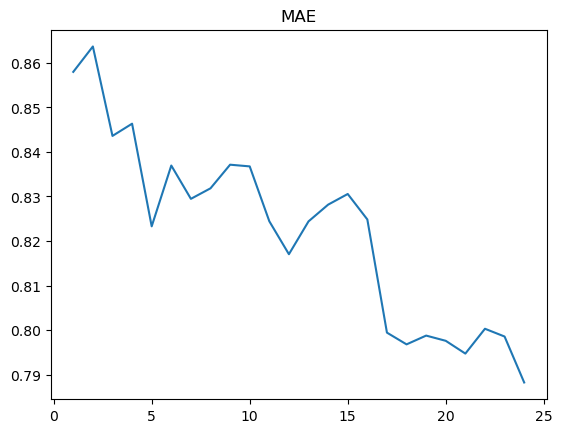

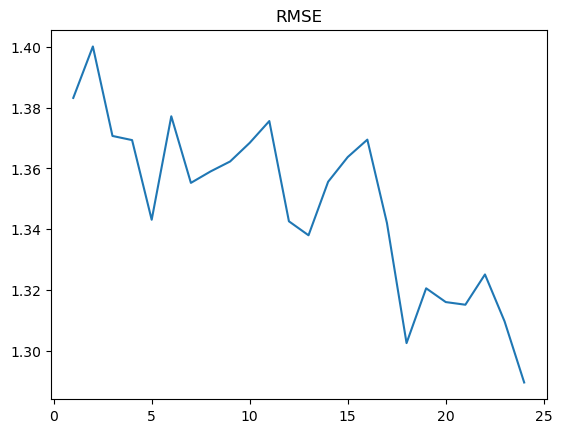

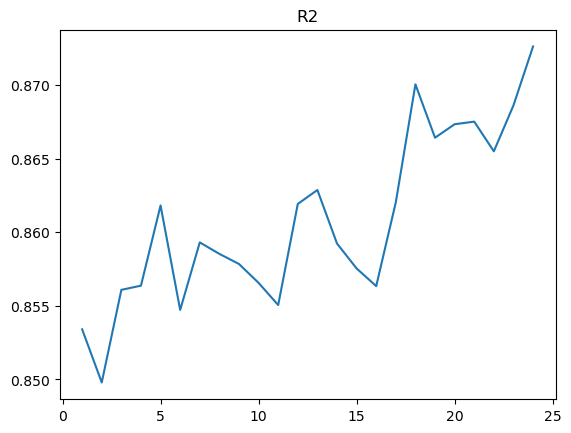

In [123]:
#plot mae, rsme and r2 over x
reals, preds = [], []
maes,rmses,r2s = [],[],[]
from sklearn.metrics import r2_score
for output in outputs:
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    reals.append(real)
    preds.append(pred)
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
import matplotlib.pyplot as plt
plt.plot(range(1,len(maes)+1), maes)
plt.title('MAE')
plt.show()
plt.plot(range(1,len(rmses)+1), rmses)
plt.title('RMSE')
plt.show()
plt.plot(range(1,len(r2s)+1), r2s)
plt.title('R2')
plt.show()

[1, 3, 5, 10, 15, 16, 18, 19, 21, 22]
['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'MaxPartialCharge', 'BalabanJ', 'MolWt', 'BCUT2D_CHGLO', 'FpDensityMorgan3', 'FpDensityMorgan2', 'VSA_EState3', 'PEOE_VSA8']


5it [00:00,  7.91it/s]
5it [00:00, 14.08it/s]
5it [00:00, 14.09it/s]
5it [00:00, 12.45it/s]
5it [00:00, 16.89it/s]
5it [00:00, 13.36it/s]
5it [00:00, 16.26it/s]
5it [00:00, 10.60it/s]
5it [00:00, 14.29it/s]
5it [00:00, 14.02it/s]


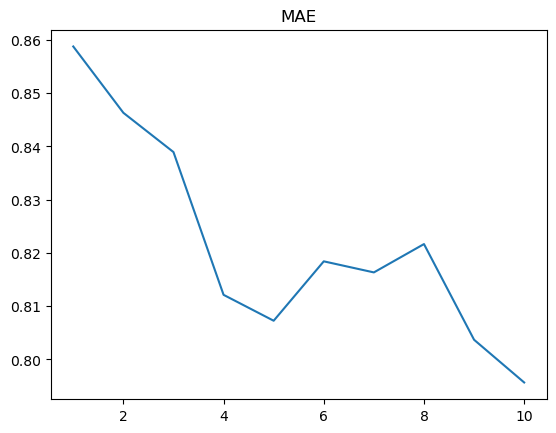

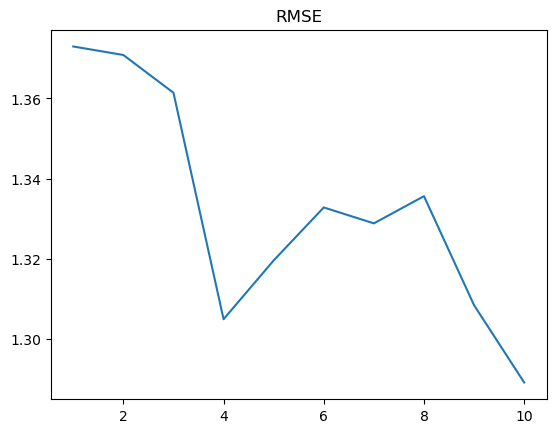

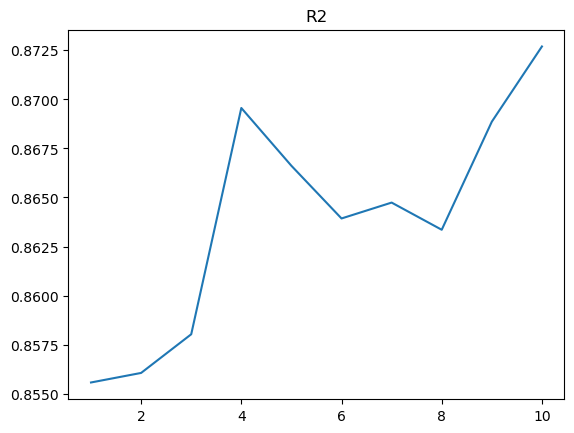

In [126]:
#okay, idk if this makes sense but do this:
#get a list of features for which there is a jump down in the MAE and RMSE and up in R2

#first get the indices of the jumps
mae_jumps = []
rmse_jumps = []
r2_jumps = []
for i in range(len(maes)-1):
    if maes[i+1] < maes[i]:
        mae_jumps.append(i)
    if rmses[i+1] < rmses[i]:
        rmse_jumps.append(i)
    if r2s[i+1] > r2s[i]:
        r2_jumps.append(i)

#check for overlap
overlap = [i for i in mae_jumps if i in rmse_jumps and i in r2_jumps]
print(overlap)
sorted_feature_importance_dict = sorted(feature_importance_dict.items(), key=operator.itemgetter(1), reverse=True)
selected_features = [sorted_feature_importance_dict[i][0] for i in overlap]
print(selected_features)
outputs = []
for x in range(1,len(selected_features)+1):
    added_features = selected_features[:x]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    outputs.append(output)

#plot mae, rsme and r2 over x
reals, preds = [], []
maes,rmses,r2s = [],[],[]
from sklearn.metrics import r2_score
for output in outputs:
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    reals.append(real)
    preds.append(pred)
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
import matplotlib.pyplot as plt
plt.plot(range(1,len(maes)+1), maes)
plt.title('MAE')
plt.show()
plt.plot(range(1,len(rmses)+1), rmses)
plt.title('RMSE')
plt.show()
plt.plot(range(1,len(r2s)+1), r2s)
plt.title('R2')
plt.show()

[0, 1, 2, 5, 7, 8]
['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MaxPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MRLOW']


5it [00:01,  3.39it/s]
5it [00:00, 15.05it/s]
5it [00:00, 14.10it/s]
5it [00:00, 16.01it/s]
5it [00:00, 15.75it/s]
5it [00:00, 12.60it/s]


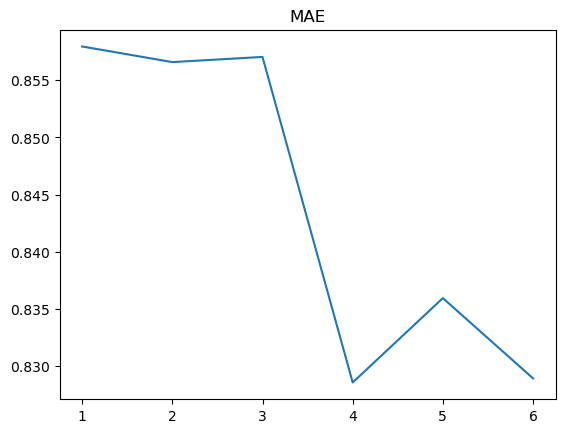

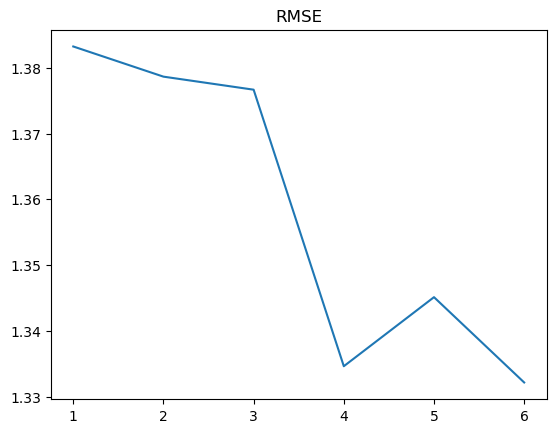

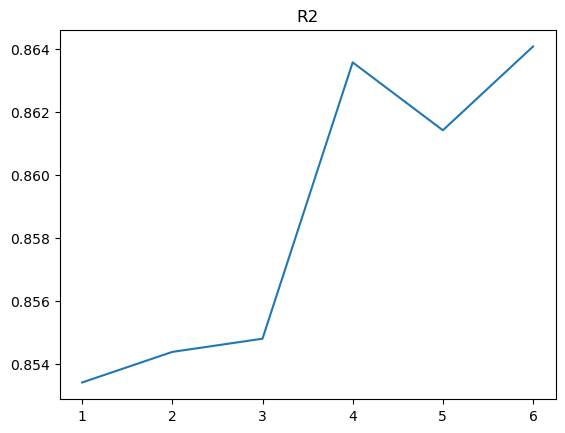

In [127]:
#okay, idk if this makes sense but do this:
#get a list of features for which there is a jump down in the MAE and RMSE and up in R2

#first get the indices of the jumps
mae_jumps = []
rmse_jumps = []
r2_jumps = []
for i in range(len(maes)-1):
    if maes[i+1] < maes[i]:
        mae_jumps.append(i)
    if rmses[i+1] < rmses[i]:
        rmse_jumps.append(i)
    if r2s[i+1] > r2s[i]:
        r2_jumps.append(i)

#check for overlap
overlap = [i for i in mae_jumps if i in rmse_jumps and i in r2_jumps]
print(overlap)
sorted_feature_importance_dict = sorted(feature_importance_dict.items(), key=operator.itemgetter(1), reverse=True)
selected_features = [sorted_feature_importance_dict[i][0] for i in overlap]
print(selected_features)
outputs = []
for x in range(1,len(selected_features)+1):
    added_features = selected_features[:x]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    outputs.append(output)

#plot mae, rsme and r2 over x
reals, preds = [], []
maes,rmses,r2s = [],[],[]
from sklearn.metrics import r2_score
for output in outputs:
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    reals.append(real)
    preds.append(pred)
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)
import matplotlib.pyplot as plt
plt.plot(range(1,len(maes)+1), maes)
plt.title('MAE')
plt.show()
plt.plot(range(1,len(rmses)+1), rmses)
plt.title('RMSE')
plt.show()
plt.plot(range(1,len(r2s)+1), r2s)
plt.title('R2')
plt.show()

In [130]:
#okay try with the top 10 features
top10_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'MaxPartialCharge', 'BalabanJ', 'MolWt', 'BCUT2D_CHGLO', 'FpDensityMorgan3', 'FpDensityMorgan2', 'VSA_EState3', 'PEOE_VSA8']

for x in range(len(top10_features)):
    #drop index x from top10_features
    added_features = top10_features[:x] + top10_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top10_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:00,  7.28it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.799490673825272
RMSE: 1.3125562604430525
R2: 0.8680392590404579



5it [00:00, 14.15it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8060385122914079
RMSE: 1.3052577233850469
R2: 0.8695027279167669



5it [00:00, 10.96it/s]


Feature dropped: MaxPartialCharge
MAE: 0.7944877188366595
RMSE: 1.2972196007239456
R2: 0.8711050524168363



5it [00:00, 14.17it/s]


Feature dropped: BalabanJ
MAE: 0.819953457713813
RMSE: 1.3451155147586678
R2: 0.8614112257044726



5it [00:00,  6.99it/s]


Feature dropped: MolWt
MAE: 0.7983348880892869
RMSE: 1.3038949834744764
R2: 0.8697750741438379



5it [00:00, 11.05it/s]


Feature dropped: BCUT2D_CHGLO
MAE: 0.8050232604926459
RMSE: 1.30975439491063
R2: 0.8686020411956696



5it [00:00, 17.49it/s]


Feature dropped: FpDensityMorgan3
MAE: 0.8062546745624664
RMSE: 1.3064618791185518
R2: 0.8692618382912309



5it [00:00, 12.55it/s]


Feature dropped: FpDensityMorgan2
MAE: 0.7970946944625963
RMSE: 1.3076844596634438
R2: 0.8690170355559834



5it [00:00, 12.22it/s]


Feature dropped: VSA_EState3
MAE: 0.8083971821703494
RMSE: 1.316975701052402
R2: 0.867149126565336



5it [00:00, 12.58it/s]

Feature dropped: PEOE_VSA8
MAE: 0.8036877925006749
RMSE: 1.3084545555596507
R2: 0.8688627182913355



In [132]:
#okay try with the top 10 features
top9_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'MolWt', 'BCUT2D_CHGLO', 'FpDensityMorgan3', 'FpDensityMorgan2', 'VSA_EState3', 'PEOE_VSA8']

for x in range(len(top9_features)):
    #drop index x from top10_features
    added_features = top9_features[:x] + top9_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top9_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:01,  4.72it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.8010526281048104
RMSE: 1.3108176731770425
R2: 0.8683886129303696



5it [00:00, 14.21it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8054502872473713
RMSE: 1.3122844990550742
R2: 0.8680938976455255



5it [00:00, 11.32it/s]


Feature dropped: BalabanJ
MAE: 0.8185826161373813
RMSE: 1.3392211729464094
R2: 0.8626231659120055



5it [00:00, 13.37it/s]


Feature dropped: MolWt
MAE: 0.7980926931485532
RMSE: 1.2917302391476213
R2: 0.8721936174108507



5it [00:00,  9.18it/s]


Feature dropped: BCUT2D_CHGLO
MAE: 0.7903531416760965
RMSE: 1.2785936116370566
R2: 0.8747799276654773



5it [00:00, 16.24it/s]


Feature dropped: FpDensityMorgan3
MAE: 0.8027006456316894
RMSE: 1.307603198437836
R2: 0.8690333139562272



5it [00:00, 15.65it/s]


Feature dropped: FpDensityMorgan2
MAE: 0.8101935710481033
RMSE: 1.3017072757199375
R2: 0.8702116968512119



5it [00:00, 15.09it/s]


Feature dropped: VSA_EState3
MAE: 0.8247572667040556
RMSE: 1.3312453132755293
R2: 0.8642546150029665



5it [00:00, 12.50it/s]

Feature dropped: PEOE_VSA8
MAE: 0.8082980964328454
RMSE: 1.3084567660233237
R2: 0.868862275212222



In [133]:
#okay try with the top 10 features
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'MolWt', 'FpDensityMorgan3', 'FpDensityMorgan2', 'VSA_EState3', 'PEOE_VSA8']

for x in range(len(top_features)):
    #drop index x from top10_features
    added_features = top_features[:x] + top_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:01,  4.08it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.8079428516488568
RMSE: 1.316284756632579
R2: 0.867288489030944



5it [00:00, 11.07it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8057370000010677
RMSE: 1.3107060671892348
R2: 0.868374818001205



5it [00:00,  9.12it/s]


Feature dropped: BalabanJ
MAE: 0.8115447843976692
RMSE: 1.3284518921516586
R2: 0.8648237004763801



5it [00:00, 11.50it/s]


Feature dropped: MolWt
MAE: 0.8001471218920962
RMSE: 1.2932875316421448
R2: 0.8718852683617728



5it [00:00, 13.88it/s]


Feature dropped: FpDensityMorgan3
MAE: 0.8055854811706112
RMSE: 1.3025984754908357
R2: 0.8700339197067293



5it [00:00, 12.32it/s]


Feature dropped: FpDensityMorgan2
MAE: 0.7830731828554917
RMSE: 1.269621068188157
R2: 0.8765312273654052



5it [00:00, 12.68it/s]


Feature dropped: VSA_EState3
MAE: 0.8196328843376011
RMSE: 1.3195431200459704
R2: 0.8666306411844305



5it [00:00, 11.68it/s]

Feature dropped: PEOE_VSA8
MAE: 0.8015172056372297
RMSE: 1.299790160547881
R2: 0.8705937119219



In [134]:
#okay try with the top 10 features
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'MolWt', 'FpDensityMorgan3', 'VSA_EState3', 'PEOE_VSA8']

for x in range(len(top_features)):
    #drop index x from top10_features
    added_features = top_features[:x] + top_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:01,  3.27it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.7988652441866458
RMSE: 1.3031093609825417
R2: 0.8699319530503065



5it [00:00, 12.40it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8010875614325302
RMSE: 1.3075620750659895
R2: 0.8690055196059114



5it [00:00,  9.71it/s]


Feature dropped: BalabanJ
MAE: 0.811904347522075
RMSE: 1.3310287982278497
R2: 0.8642987669381927



5it [00:00, 10.50it/s]


Feature dropped: MolWt
MAE: 0.7983109235620525
RMSE: 1.2809048512701895
R2: 0.8743268123526767



5it [00:00, 11.59it/s]


Feature dropped: FpDensityMorgan3
MAE: 0.8025657591108172
RMSE: 1.2971663806529201
R2: 0.8711156283556295



5it [00:00, 11.83it/s]


Feature dropped: VSA_EState3
MAE: 0.817682852968032
RMSE: 1.3251109188099712
R2: 0.8655027653597505



5it [00:00, 11.79it/s]

Feature dropped: PEOE_VSA8
MAE: 0.8011244170555664
RMSE: 1.3034224436004669
R2: 0.8698694457308627



In [135]:
#okay try with the top 10 features
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'FpDensityMorgan3', 'VSA_EState3', 'PEOE_VSA8']

for x in range(len(top_features)):
    #drop index x from top10_features
    added_features = top_features[:x] + top_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:01,  3.19it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.8085642289114947
RMSE: 1.322680710152735
R2: 0.8659956397563243



5it [00:00,  6.83it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8202645509439975
RMSE: 1.3336532991280554
R2: 0.8637256081906609



5it [00:00,  6.71it/s]


Feature dropped: BalabanJ
MAE: 0.825752284317394
RMSE: 1.3456381088709393
R2: 0.8613035178595814



5it [00:00, 10.38it/s]


Feature dropped: FpDensityMorgan3
MAE: 0.797381057416246
RMSE: 1.2855842124350898
R2: 0.8734069245203084



5it [00:00,  9.30it/s]


Feature dropped: VSA_EState3
MAE: 0.8348183687936417
RMSE: 1.339387667335271
R2: 0.8625890059177181



5it [00:00, 13.23it/s]

Feature dropped: PEOE_VSA8
MAE: 0.8038661119108452
RMSE: 1.2939330480339482
R2: 0.8717573450712832



In [136]:
#okay try with the top 10 features
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'VSA_EState3', 'PEOE_VSA8']

for x in range(len(top_features)):
    #drop index x from top10_features
    added_features = top_features[:x] + top_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:00,  7.31it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.8001209175479794
RMSE: 1.3074299131347589
R2: 0.8690680234126615



5it [00:00, 11.52it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8226568499080523
RMSE: 1.325120558623319
R2: 0.865463802418187



5it [00:00, 11.55it/s]


Feature dropped: BalabanJ
MAE: 0.8248671174503527
RMSE: 1.33535051871988
R2: 0.863416119028228



5it [00:00, 10.15it/s]


Feature dropped: VSA_EState3
MAE: 0.8099002086394367
RMSE: 1.3168060205965217
R2: 0.8671833576366776



5it [00:00, 13.21it/s]

Feature dropped: PEOE_VSA8
MAE: 0.8059275271355838
RMSE: 1.302288818045318
R2: 0.8700957041807795



In [137]:
#okay try with the top 10 features
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'VSA_EState3']

for x in range(len(top_features)):
    #drop index x from top10_features
    added_features = top_features[:x] + top_features[x+1:]
    
    #X will be the mdfp features + the mol features
    X = df_mdfps_features[mdfp_features+added_features]
    y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
    X = X.dropna()
    y = y[X.index]
    #now do the cross validation
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)

    params = params
    output = ([], [])

    for train, test in tqdm.tqdm(kf.split(X)):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)
            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
    
            )
            # Evaluate the model
            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)
    real, pred = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    mae = mean_absolute_error(np.array(real), np.array(pred))
    rmse = mean_squared_error(np.array(real), np.array(pred), squared=False)
    r2 = r2_score(np.array(real), np.array(pred))
    print(f'Feature dropped: {top_features[x]}' )
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print('')




5it [00:01,  2.52it/s]


Feature dropped: MinAbsEStateIndex
MAE: 0.8097838696070382
RMSE: 1.3190929175050548
R2: 0.8667216317409568



5it [00:00, 13.91it/s]


Feature dropped: BCUT2D_CHGHI
MAE: 0.8250596104752789
RMSE: 1.3298452917264216
R2: 0.8645027112529793



5it [00:00, 11.60it/s]


Feature dropped: BalabanJ
MAE: 0.8164391994083795
RMSE: 1.3350265874111549
R2: 0.8634823764315556



5it [00:00, 14.12it/s]

Feature dropped: VSA_EState3
MAE: 0.8278323912942968
RMSE: 1.329845294049056
R2: 0.8645399812159599



okay now we'll do two plots: one with best performance, regardless of number of features, and one with best performance with minimum added features
or lets do three;
1. Just any amount of extra features
2. Minimum amount extra features
3. No extra features


In [143]:
#1. Most import features (many)
most_important_features_many = [f[0] for f in sorted_feature_importance_dict[:34]]

#X will be the mdfp features + the mol features
X = df_mdfps_features[mdfp_features+most_important_features_many]
y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
X = X.dropna()
y = y[X.index]
#now do the cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

params = params
output = ([], [])

for train, test in tqdm.tqdm(kf.split(X)):
        
        train_x = np.array(X)[train]
        train_y = np.array(y)[train]

        test_x = np.array(X)[test]
        test_y = np.array(y)[test]
        
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)
        model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

        )
        # Evaluate the model
        predictions = model.predict(dtest)

        output[0].append(test_y)
        output[1].append(predictions)

5it [00:00,  6.95it/s]


In [144]:
real_many, pred_many = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))

In [145]:
#1. Most import features (many)
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'VSA_EState3']

#X will be the mdfp features + the mol features
X = df_mdfps_features[mdfp_features+top_features]
y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
X = X.dropna()
y = y[X.index]
#now do the cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

params = params
output = ([], [])

for train, test in tqdm.tqdm(kf.split(X)):
        
        train_x = np.array(X)[train]
        train_y = np.array(y)[train]

        test_x = np.array(X)[test]
        test_y = np.array(y)[test]
        
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)
        model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

        )
        # Evaluate the model
        predictions = model.predict(dtest)

        output[0].append(test_y)
        output[1].append(predictions)

5it [00:00, 11.65it/s]


In [146]:
real_top, pred_top = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))

In [156]:
#1. Most import features (many)
top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'VSA_EState3']

#X will be the mdfp features + the mol features
X = df_mdfps_features[top_features]
y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
X = X.dropna()
y = y[X.index]
#now do the cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

params = params
output = ([], [])

for train, test in tqdm.tqdm(kf.split(X)):
        
        train_x = np.array(X)[train]
        train_y = np.array(y)[train]

        test_x = np.array(X)[test]
        test_y = np.array(y)[test]
        
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)
        model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

        )
        # Evaluate the model
        predictions = model.predict(dtest)

        output[0].append(test_y)
        output[1].append(predictions)

5it [00:00, 17.87it/s]


In [157]:
real_top2d_only_no_mdfp, pred_top2d_only_no_mdfp = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))

In [147]:
#1. Most import features (many)

#X will be the mdfp features + the mol features
X = df_mdfps_features[mdfp_features]
y = df_mdfps_features['vp']

# remove rows with NaNs from X and y
X = X.dropna()
y = y[X.index]
#now do the cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

params = params
output = ([], [])

for train, test in tqdm.tqdm(kf.split(X)):
        
        train_x = np.array(X)[train]
        train_y = np.array(y)[train]

        test_x = np.array(X)[test]
        test_y = np.array(y)[test]
        
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)
        model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

        )
        # Evaluate the model
        predictions = model.predict(dtest)

        output[0].append(test_y)
        output[1].append(predictions)

5it [00:00, 12.83it/s]


In [148]:
real_no, pred_no = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))

RMSE:  1.4098133564395878
MAE:  0.8777791918205883
R2:  0.8479669714637511


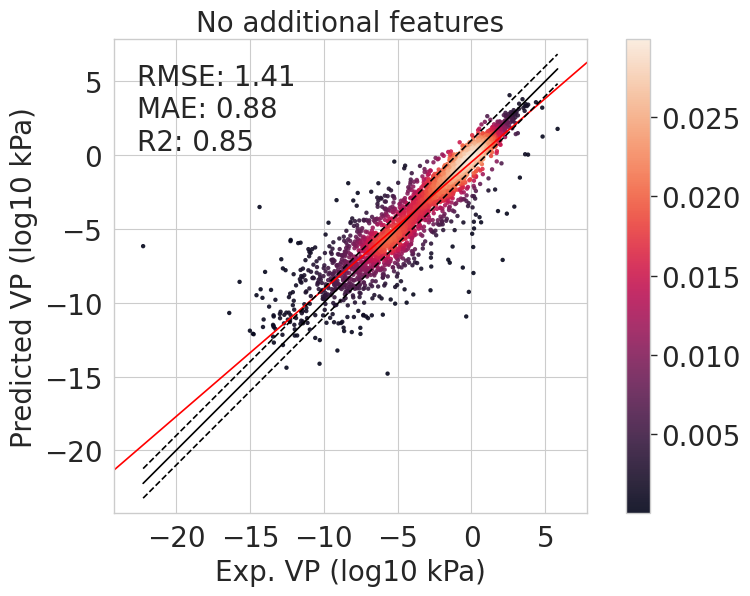

RMSE:  1.302288818045318
MAE:  0.8059275271355838
R2:  0.870262034066105


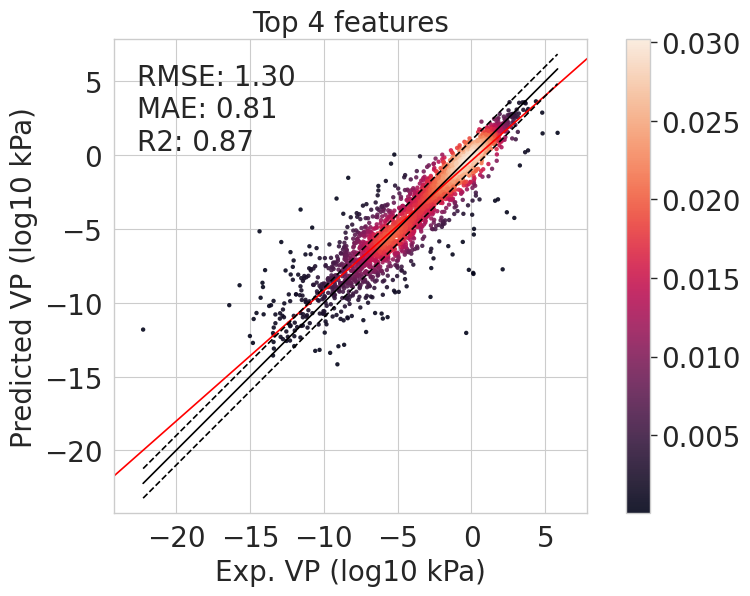

RMSE:  1.2557911447802514
MAE:  0.7620936388822558
R2:  0.8793610059057155


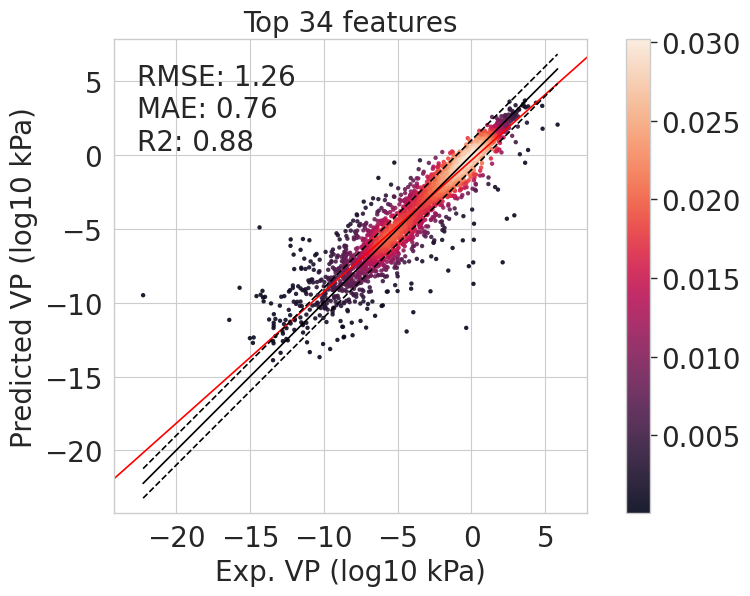

RMSE:  2.1779821751347903
MAE:  1.5404240906952953
R2:  0.636948643870732


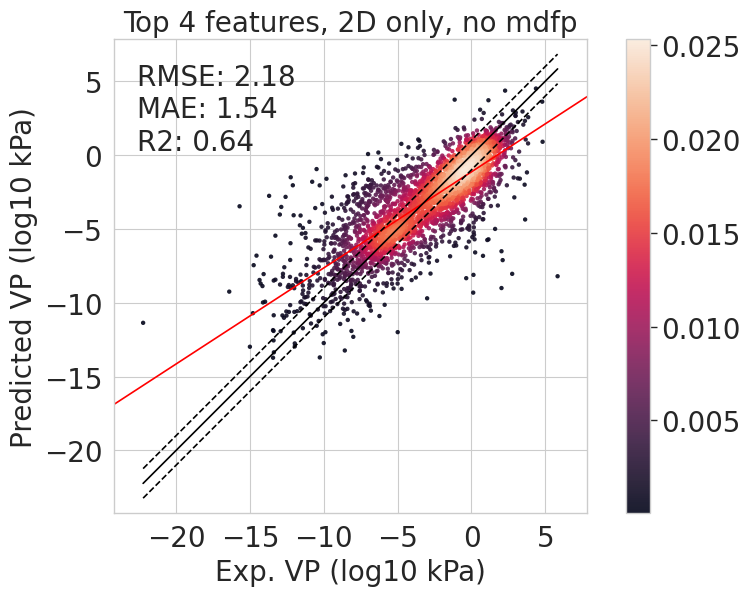

In [158]:
#now do three subplots of function density_plot next to eachother

density_plot(real_no, pred_no, title='No additional features')
density_plot(real_top, pred_top, title='Top 4 features')
density_plot(real_many, pred_many, title='Top 34 features')
density_plot(real_top2d_only_no_mdfp, pred_top2d_only_no_mdfp, title='Top 4 features, 2D only, no mdfp')

In [159]:
#okay and what if we also go the HP-optimized, conformer-augmented?
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
'''
# Execute the SQL query
cur.execute(sql_query)
data_full = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
data_full['mdfp'] = data_full['mdfp'].apply(lambda x: json.loads(x['mdfp']))

In [169]:
merged_df = data_full.merge(df_mdfps_features, on='molregno', how='left')

# Resulting dataframe
merged_df[merged_df['molregno'] == 7]
#splendid! drop vp_x and change vp_y to vp
merged_df = merged_df.drop(columns=['vp_x'])
merged_df = merged_df.rename(columns={'vp_y': 'vp'})
#same for confid
merged_df = merged_df.drop(columns=['confid_x'])
merged_df = merged_df.rename(columns={'confid_y': 'confid'})
#and mdfp
merged_df = merged_df.drop(columns=['mdfp_x'])
merged_df = merged_df.rename(columns={'mdfp_y': 'mdfp'})
merged_df


,molregno,confid,mdfp,vp,NumHeavyAtoms,NumRotatableBonds,NumN,NumO,NumF,NumP,NumS,NumCl,NumBr,NumI,water_intra_crf_mean,water_intra_crf_std,water_intra_crf_median,water_intra_lj_mean,water_intra_lj_std,water_intra_lj_median,water_total_crf_mean,water_total_crf_std,water_total_crf_median,water_total_lj_mean,water_total_lj_std,water_total_lj_median,water_intra_ene_mean,water_intra_ene_std,water_intra_ene_median,water_total_ene_mean,water_total_ene_std,water_total_ene_median,water_rgyr_mean,water_rgyr_std,water_rgyr_median,water_sasa_mean,water_sasa_std,water_sasa_median,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,7,1150,"[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.3614322526332...",-0.301067,9,5,0,0,0,0,0,0,0,0,7.361432,0.283715,7.340421,14.033742,5.018821,13.296542,3.017586,4.353506,3.780432,-52.022869,7.644485,-52.451038,21.395174,4.952106,20.619065,-49.005283,8.735996,-49.230909,0.292018,0.017856,0.292419,3.817920,0.071479,3.822621,7.705208,7.705208,1.660585,-4.205634,0.390240,126.243,108.099,126.140851,54,0,0.057236,-0.091664,0.091664,0.057236,1.555556,2.555556,3.333333,-7.508532e-02,-0.248537,-6.224632e-01,-2.666135,-5.668012e-01,-2.514462,-2.165186e-01,-1.148516,2.418145,6.657181,584.934006,22.654701,22.500000,4.500000,11.315384,11.000000,2.000000,0.875000,0.875000,0.375000,0.375000,0.156250,0.156250,-0.26,9.261253e+04,0.790271,7.740000,7.740000,84.258654,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,38.074810,19.597742,21.932137,2.741517,24.673654,0.000000,0.000000,0.000000,0.000000,45.568409,0.000000,12.104143,0.0,0.000000,0.

In [172]:
params = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}

gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
df = merged_df
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))

y = df['vp']  
params = params
output = ([],[],[],[])

top_features = ['MinAbsEStateIndex', 'BCUT2D_CHGHI', 'BalabanJ', 'VSA_EState3']
X = df[mdfp_features+top_features]
y = df['vp']
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):
    #X is the mdfp features + top 4 features
    #1. Most import features (many)

    #X will be the mdfp features + the mol features
    # Split the data into train and test sets for this fold
    X_train = np.array(X.iloc[train_idx]) # Convert lists to NumPy arrays
    X_test = np.array(X.iloc[test_idx])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


    # Create DMatrix for training and testing
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(y_test)
    output[1].append(pp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    rmse = np.sqrt(mean_squared_error(y_test, pp, squared=False))
    print(f"Fold {fold + 1}: RMSE = {rmse}")



/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.252924929854186


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1108148113613154


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.1802523566408023


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.0628812388720958


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1762379851451674


RMSE:  1.2896913866779636
MAE:  0.7659735655517161
R2:  0.8728672741709426


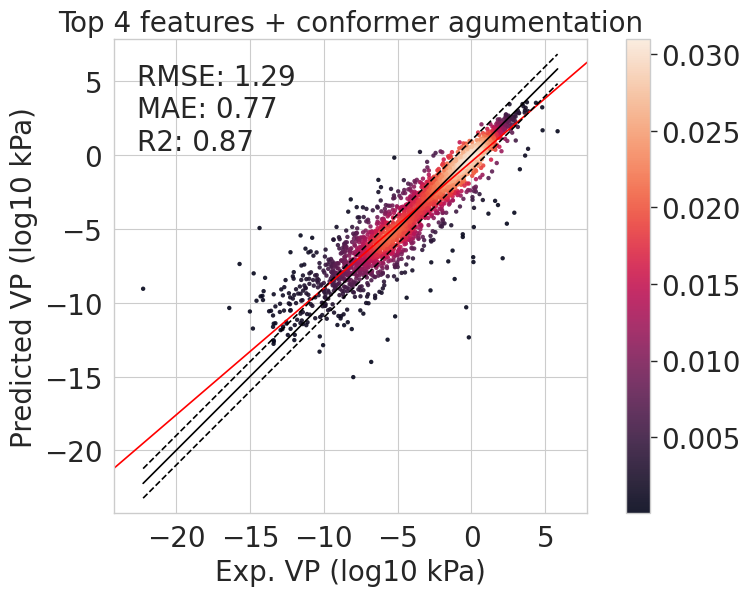

In [174]:
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction = df_preds['pred'].tolist()
real = df_preds['vp'].tolist()
density_plot(real,prediction,title='Top 4 features + conformer agumentation')
slope_conf_augmented_averaged, intercept_conf_augmented_averaged, r2_conf_augmented_averaged, rmse_conf_augmented_averaged, mae_conf_augmented_averaged = getStatValues(prediction, real)

In [179]:
#okay, now I actually want to look at prediction error of only 2d vs only mdfp per mol, and look at the difference
params = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}

gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []
df = merged_df
# Group the data by 'molregno'
groups = df['molregno']

# Iterate over each fold
for train_idx, test_idx in gkf.split(df, groups=groups):
    fold_indices.append((train_idx, test_idx))

y = df['vp']  
params = params
output = ([],[],[],[],[])
selection_2d_features = ['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'BCUT2D_CHGHI', 'MinPartialCharge', 'MaxPartialCharge', 'MinEStateIndex', 'FpDensityMorgan1', 'BCUT2D_MRLOW', 'BCUT2D_MWLOW', 'BalabanJ', 'BCUT2D_MWHI', 'BCUT2D_LOGPHI', 'Kappa3', 'BCUT2D_LOGPLOW', 'MolWt', 'BCUT2D_CHGLO', 'PEOE_VSA6', 'FpDensityMorgan3', 'FpDensityMorgan2', 'PEOE_VSA7', 'VSA_EState3', 'PEOE_VSA8', 'BertzCT', 'MinAbsPartialCharge', 'BCUT2D_MRHI', 'VSA_EState8', 'AvgIpc', 'EState_VSA3', 'TPSA', 'VSA_EState7', 'EState_VSA6', 'VSA_EState4', 'VSA_EState5', 'Chi3v', 'PEOE_VSA9', 'EState_VSA5', 'MolLogP', 'Kappa2', 'Chi2n', 'SMR_VSA5', 'MaxAbsPartialCharge']

X_mdfp = df[mdfp_features]
X_2d = df[selection_2d_features]
y = df['vp']
# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):
    #X is the mdfp features + top 4 features
    #1. Most import features (many)

    #X will be the mdfp features + the mol features
    # Split the data into train and test sets for this fold
    X_train_mdfp = np.array(X_mdfp.iloc[train_idx]) # Convert lists to NumPy arrays
    X_test_mdfp = np.array(X_mdfp.iloc[test_idx])

    X_train_2d = np.array(X_2d.iloc[train_idx]) # Convert lists to NumPy arrays
    X_test_2d = np.array(X_2d.iloc[test_idx])

    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


    # Create DMatrix for training and testing
    dtrain_mdfp = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_mdfp = xgb.DMatrix(X_test_mdfp, label=y_test)

    dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train)
    dtest_2d = xgb.DMatrix(X_test_2d, label=y_test)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )

    model_2d = xgb.train(
        params,
        dtrain_2d,
        num_boost_round=999,
        evals=[(dtest_2d, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp_mdfp = model_mdfp.predict(dtest_mdfp)
    pp_2d = model_2d.predict(dtest_2d)

    output[0].append(y_test)
    output[1].append(pp_mdfp)
    molregnos_test = df['molregno'].iloc[test_idx]
    confids_test = df['confid'].iloc[test_idx]
    
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    output[4].append(pp_2d)

    rmse_mdfp = np.sqrt(mean_squared_error(y_test, pp_mdfp, squared=False))
    rmse_2d = np.sqrt(mean_squared_error(y_test, pp_2d, squared=False))
    print(f"Fold {fold + 1}: MDFP RMSE = {rmse_mdfp}, 2D RMSE = {rmse_2d}")



/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: MDFP RMSE = 2.3956504514297383, 2D RMSE = 1.237610579956882


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: MDFP RMSE = 2.366956565695942, 2D RMSE = 1.04136381949175


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: MDFP RMSE = 2.4059992036113633, 2D RMSE = 1.152271473071624


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: MDFP RMSE = 2.4978630530077615, 2D RMSE = 1.0502931995601983


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: MDFP RMSE = 2.4341531237404626, 2D RMSE = 1.1515202413661751


In [184]:
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds_mdfp = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
preds_2d = reduce(lambda a,b : list(a)+list(b), output[4])

df_preds = pd.DataFrame({'vp': vps, 'pred_mdfp': preds_mdfp, 'pred_2d': preds_2d, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
#drop confid
df_preds = df_preds.drop(columns=['confid'])
#get abs error for both preds
df_preds['abs_error_mdfp'] = abs(df_preds['vp'] - df_preds['pred_mdfp'])
df_preds['abs_error_2d'] = abs(df_preds['vp'] - df_preds['pred_2d'])
df_preds

,vp,pred_mdfp,pred_2d,abs_error_mdfp,abs_error_2d
molregno,,,,,
1,1.100855,0.672994,1.243085,0.427861,0.142229
6,-14.744727,1.196028,-7.840155,15.940755,6.904573
7,-0.301067,1.017324,0.177289,1.318391,0.478356
8,-6.053323,1.502689,-6.116629,7.556011,0.063306
9,0.591625,1.103196,0.929838,0.511572,0.338213
...,...,...,...,...,...
4240,-7.301899,1.103196,-7.087374,8.405096,0.214525
4241,-8.356584,0.901213,-7.977694,9.257797,0.378890
4242,-6.770000,1.472264,-6.819067,8.242264,0.049067


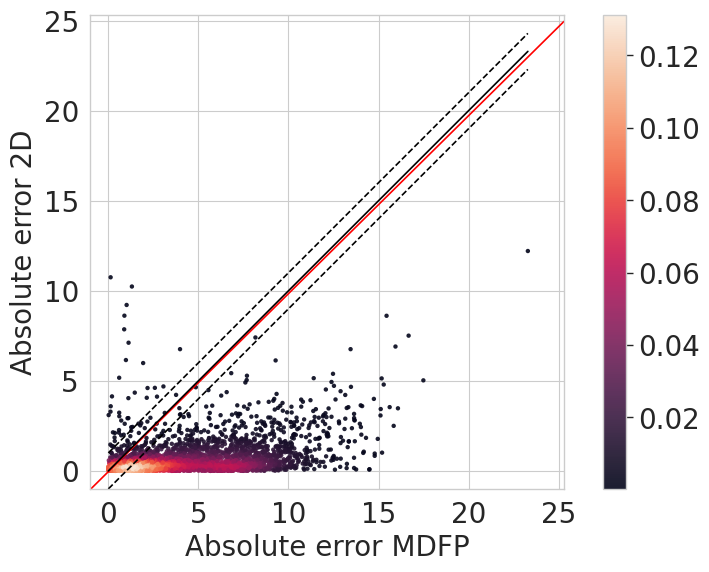

In [189]:
fsize = 20
real = df_preds['abs_error_mdfp'].tolist()
prediction = df_preds['abs_error_2d'].tolist()
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = -1
upper = max(prediction + real) + 2
x = np.linspace(lower, upper,100)
y = slope_mdfp_d*x+intercept_mdfp_d
plt.plot(x, y, '-r')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction],var_type='cc', bw='normal_reference')
z = dens_u.pdf([real, prediction])

sc = plt.scatter(real, prediction, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.xlabel(r'Absolute error MDFP', fontsize=fsize)
plt.ylabel(r'Absolute error 2D', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=fsize)
plt.setp(ax.get_yticklabels(), fontsize=fsize)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
#make square
ax.set_aspect('equal', 'box')
plt.show()

Text(0, 0.5, 'Count')

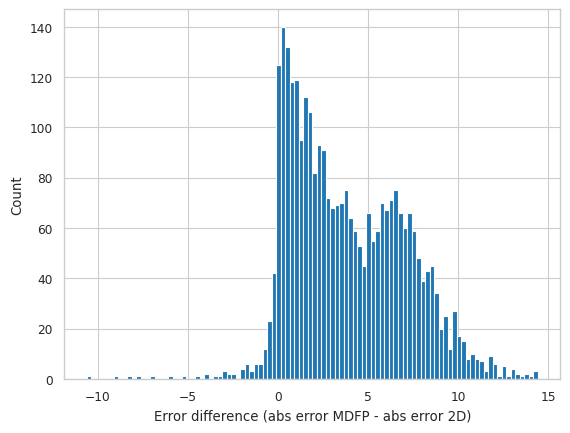

In [191]:
df['error_difference'] = df_preds['abs_error_mdfp'] - df_preds['abs_error_2d']
#plot
plt.hist(df['error_difference'], bins=100)
plt.xlabel('Error difference (abs error MDFP - abs error 2D)')
plt.ylabel('Count')


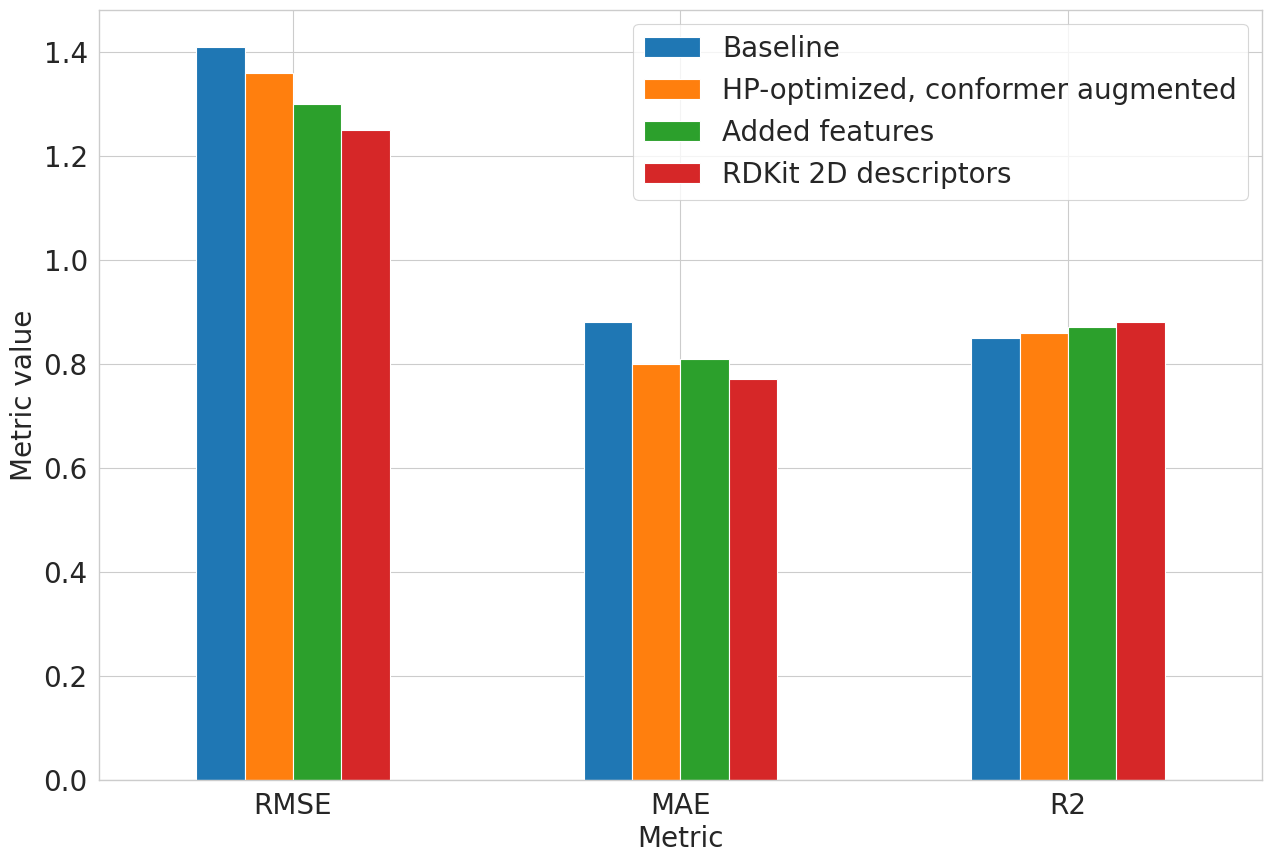

In [205]:
#df with number we have so far
baseline = {'RMSE': 1.41, 'MAE': 0.88, 'R2': 0.85}
hp_opt_conf_aug = {'RMSE': 1.36, 'MAE': 0.80, 'R2': 0.86}
added_feautres = {'RMSE': 1.30, 'MAE': 0.81, 'R2': 0.87}
rdkit_2d_descriptors = {'RMSE': 1.25, 'MAE': 0.77, 'R2': 0.88}
#make df
df_results = pd.DataFrame([baseline, hp_opt_conf_aug, added_feautres, rdkit_2d_descriptors], index=['Baseline', 'HP-optimized, conformer augmented', 'Added features', 'RDKit 2D descriptors'])
df_results
#barplot grouped by method
#barplot grouped by metric
df_results.T.plot.bar(rot=0, figsize=(15,10))
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
#add axis labels
plt.ylabel('Metric value', fontsize=20)
plt.xlabel('Metric', fontsize=20)
#bigger ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#bigger legend fontsize
plt.legend(fontsize=20)




In [207]:
df_mdfps_features.to_csv('mdfp_and_rdkit_features_all_mols.csv')

In [12]:
#test: influence of training set size by amount of folds
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
reals,preds,splits = [],[],[]
for i in range(2,21):
    output = train_pred_xgboost(df_mdfps,params,splits=i)
    real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    reals.append(real)
    preds.append(prediction)
    splits.append(i)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2051206926142137


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.2173412317107695


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.1337355035711432


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.2328757549556175
Fold 3: RMSE = 1.2252033641648292


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.1816260995651517
Fold 2: RMSE = 1.1939231266642978


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.204024819992597
Fold 4: RMSE = 1.1720851136179393
Fold 1: RMSE = 1.2120086081380206


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1813995099300418
Fold 3: RMSE = 1.1496915511718304


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.2512689517410922
Fold 5: RMSE = 1.1285220740756896


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.1340490965792631
Fold 2: RMSE = 1.253276439548329
Fold 3: RMSE = 1.1946216903918094


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1199102939544696


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.183967369585252
Fold 6: RMSE = 1.1767967421487098


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2755971009352762
Fold 2: RMSE = 1.1812432646902489
Fold 3: RMSE = 1.2883530099396865


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1497303359496496
Fold 5: RMSE = 1.075431549949018
Fold 6: RMSE = 1.1745587824993449


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.1165415740660494
Fold 1: RMSE = 1.199331534925026


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.2251162876422992
Fold 3: RMSE = 1.238718448396839


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.155709621234409
Fold 5: RMSE = 1.0971219887074604
Fold 6: RMSE = 1.172369000486687
Fold 7: RMSE = 1.1563237282826038
Fold 8: RMSE = 1.1531696809264695


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.14391658887195
Fold 2: RMSE = 1.2799101331077634


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.2647029938689427
Fold 4: RMSE = 1.0802263754367682
Fold 5: RMSE = 1.229263446475939


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.1723377291006163
Fold 7: RMSE = 1.1720497096283742
Fold 8: RMSE = 1.2432155725132905


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 1.0614945776931173
Fold 1: RMSE = 1.2097283495499862


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1022961800547626
Fold 3: RMSE = 1.100805836521072
Fold 4: RMSE = 1.2858918364136471
Fold 5: RMSE = 1.1287874992961258


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.1822992321807728
Fold 7: RMSE = 1.2153374223928748


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 1.1899740287280842
Fold 9: RMSE = 1.1460867124043588


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 1.1055055203057442
Fold 1: RMSE = 1.1450666836474384
Fold 2: RMSE = 1.1968470834897664
Fold 3: RMSE = 1.1816249944075774


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1946089417265562
Fold 5: RMSE = 1.066788910722787
Fold 6: RMSE = 1.1705907016035377


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.1655669188444109
Fold 8: RMSE = 1.1236767817231146
Fold 9: RMSE = 1.1911840218098637
Fold 10: RMSE = 1.1995453159730554


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 1.1796647464971894
Fold 1: RMSE = 1.1340255196582305


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.30381760940869
Fold 3: RMSE = 1.2177637190855821
Fold 4: RMSE = 1.1251578271431706
Fold 5: RMSE = 1.1911727311942784


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.1855891132985656
Fold 7: RMSE = 1.1736605444373194
Fold 8: RMSE = 1.210018655948134
Fold 9: RMSE = 1.1523433514159134


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 1.0529827882164942
Fold 11: RMSE = 1.1759351497737194


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 1.0923628678613566
Fold 1: RMSE = 1.2177033564064437
Fold 2: RMSE = 1.043040026502353
Fold 3: RMSE = 1.152529219124877


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1769254383674495
Fold 5: RMSE = 1.2600419864768082
Fold 6: RMSE = 1.1828482689200879
Fold 7: RMSE = 1.142339445445138


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 1.1546954490367771
Fold 9: RMSE = 1.1196779464562217
Fold 10: RMSE = 1.258497782187847
Fold 11: RMSE = 1.1907396391934724


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 1.085967373366923
Fold 13: RMSE = 1.1668364366047808


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2024540911867871
Fold 2: RMSE = 1.0338878890717496


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.268980185581922
Fold 4: RMSE = 1.1429544345182912
Fold 5: RMSE = 1.1156222159270348


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.1977717539236494
Fold 7: RMSE = 1.1913889968101157
Fold 8: RMSE = 1.2991561729926806
Fold 9: RMSE = 1.2688368856765333
Fold 10: RMSE = 1.3292205784812412


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localho

Fold 11: RMSE = 1.1117037220598558
Fold 12: RMSE = 1.046800404722322
Fold 13: RMSE = 1.1406519979109742


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 1.0753497662257068
Fold 1: RMSE = 1.178858608549632
Fold 2: RMSE = 1.1723372720891352


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.1401383362635573
Fold 4: RMSE = 1.0810914259492326
Fold 5: RMSE = 1.1179601048923817


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.2673547038618167
Fold 7: RMSE = 1.0975662730139468
Fold 8: RMSE = 1.1918303335391844


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 1.118776342163632
Fold 10: RMSE = 1.1469674570574824
Fold 11: RMSE = 1.1733716166652133
Fold 12: RMSE = 1.1541563172436118


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 1.107908997618014
Fold 14: RMSE = 1.3948223690735675
Fold 15: RMSE = 1.079224096224922


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.1331913218702505
Fold 2: RMSE = 1.1670258201897983
Fold 3: RMSE = 1.0834376692308263


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.26766829006445
Fold 5: RMSE = 1.0992751770730067
Fold 6: RMSE = 1.2165008780177373
Fold 7: RMSE = 1.1170960706873352
Fold 8: RMSE = 1.1875367254122906


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localho

Fold 9: RMSE = 1.234364712593205
Fold 10: RMSE = 1.225666217726953
Fold 11: RMSE = 1.358378602909955


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 0.9394256612995598
Fold 13: RMSE = 1.1503960542881262
Fold 14: RMSE = 1.058666651719859
Fold 15: RMSE = 1.0743390926213905


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 16: RMSE = 1.1163282647421808
Fold 1: RMSE = 1.1923494031099957


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.036896328706605
Fold 3: RMSE = 1.1434428174767444
Fold 4: RMSE = 1.1783035300930798


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.148483601757313
Fold 6: RMSE = 1.3309565779091368
Fold 7: RMSE = 1.068779017251363


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 1.042573924711108
Fold 9: RMSE = 1.0869769474396573
Fold 10: RMSE = 1.14535135988529
Fold 11: RMSE = 1.1667689212277768


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 1.2064615432086019
Fold 13: RMSE = 1.1867862438948815
Fold 14: RMSE = 1.19591398163139
Fold 15: RMSE = 1.1714621912825742
Fold 16: RMSE = 1.1198042193896962


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localho

Fold 17: RMSE = 1.2769133593931137
Fold 1: RMSE = 1.1345897882014029
Fold 2: RMSE = 1.2771556753474738


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.3548308531287487
Fold 4: RMSE = 1.1610722987681248
Fold 5: RMSE = 1.0179304221076708


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.1409201410814087
Fold 7: RMSE = 1.2317006572271223
Fold 8: RMSE = 1.156265370677451


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 1.027218564009893
Fold 10: RMSE = 1.1219325482545628


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 1.2343663536330378
Fold 12: RMSE = 1.1171497935647603
Fold 13: RMSE = 1.018450136503494


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 1.3041815984844083
Fold 15: RMSE = 1.1834687413591876
Fold 16: RMSE = 1.0260156772673263


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 17: RMSE = 1.271740470048199
Fold 18: RMSE = 1.107400495510836


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.1989703399136589
Fold 2: RMSE = 1.193362170304138
Fold 3: RMSE = 1.2352210255871363
Fold 4: RMSE = 1.2222937100862465


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1481863194366422
Fold 6: RMSE = 0.986935983264919


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.0286420996715229
Fold 8: RMSE = 1.3151269554020666
Fold 9: RMSE = 1.104456968607514


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 1.1434401454538292
Fold 11: RMSE = 1.127339272222982
Fold 12: RMSE = 1.0906705213031065


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 1.3414675646041756
Fold 14: RMSE = 1.262099702479893


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 15: RMSE = 1.10419613690278
Fold 16: RMSE = 0.9830222352606406


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 17: RMSE = 1.1726727744820218
Fold 18: RMSE = 1.1876460376568239
Fold 19: RMSE = 1.0904083463179328
Fold 1: RMSE = 1.2695516044864144
Fold 2: RMSE = 1.1080024305664438
Fold 3: RMSE = 1.1133393913239074


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.310971926747336
Fold 5: RMSE = 1.0829512722161019
Fold 6: RMSE = 1.213749300572382


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.1927466715059727
Fold 8: RMSE = 1.153315592279561
Fold 9: RMSE = 1.1453602842442234
Fold 10: RMSE = 1.087154276408801


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 1.2194959045777451
Fold 12: RMSE = 1.0808993203517538
Fold 13: RMSE = 1.0320780356817758


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 1.2720935108165876
Fold 15: RMSE = 1.1660580420900668
Fold 16: RMSE = 1.0850430063316283


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 17: RMSE = 1.2079873837116148
Fold 18: RMSE = 1.2642170953200056
Fold 19: RMSE = 1.1546473357025901


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 20: RMSE = 1.1066825696408862


In [21]:
training_set_size = []
for i in range(2,21):
    gkf = GroupKFold(n_splits=i)

    # Create an empty list to store the indices of each fold
    fold_indices = []

    # Group the data by 'molregno'
    groups = df_mdfps['molregno']

    # Iterate over each fold
    for train_idx, test_idx in gkf.split(df_mdfps, groups=groups):
        training_set_size.append(len(train_idx))
        break


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmses, maes, r2s = [],[],[]
for real,prediction in zip(reals,preds):
    rmse = np.sqrt(mean_squared_error(real, prediction, squared=False))
    mae = mean_absolute_error(real, prediction)
    r2 = r2_score(real, prediction)
    rmses.append(rmse)
    maes.append(mae)
    r2s.append(r2)

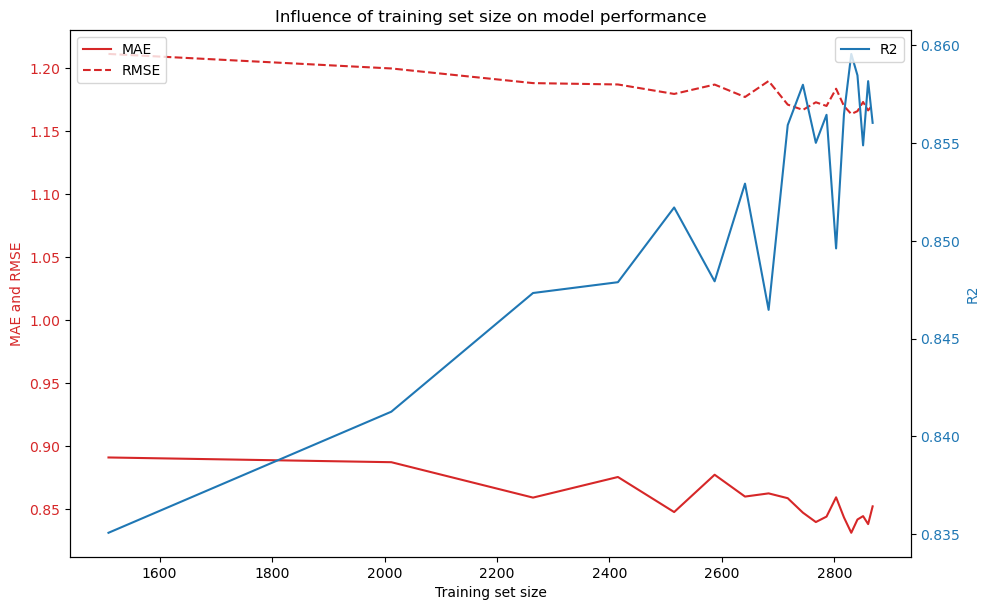

In [24]:
#plot all three metrics against number of splits. MAE and RMSE on same y axis and r2 on other
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Training set size')
ax1.set_ylabel('MAE and RMSE', color='tab:red')
ax1.plot(training_set_size, maes, color='tab:red', label='MAE')
ax1.plot(training_set_size, rmses, color='tab:red', linestyle='--', label='RMSE')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('R2', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(training_set_size, r2s, color='tab:blue', label='R2')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.xticks(splits, training_set_size)
plt.title('Influence of training set size on model performance')
plt.show()